In [1]:
# setting device on GPU if available, else CPU
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


Using device: cuda

NVIDIA GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import torch
import numpy as np
import os
import torch.nn as nn

In [4]:
from modeling_clamp import ClampModel
from configuration_clamp import ClampConfig

from feature_extraction_clamp import ClampFeatureExtractor
from transformers import RobertaTokenizer
from processing_clamp import ClampProcessor
from datasets import load_dataset, Audio

from clamp_dataset import load_dataset, simple_collate
from functools import partial

/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# from modeling_clap import ClapModel
# from transformers import AutoProcessor

In [6]:
def findAllFile(base):
    file_path = []
    for root, ds, fs in os.walk(base, followlinks=True):
        for f in fs:
            fullname = os.path.join(root, f)
            file_path.append(fullname)
    return file_path



In [ ]:
from training_config import cfg, get_cfg_defaults


In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import librosa


In [9]:
nme = "clamp_enc"
path = f"/srv/hays-lab/scratch/sanisetty3/music_motion/clamp/checkpoints/{nme}/{nme}.yaml"
cfg = get_cfg_defaults()
print("loading config from:", path)
cfg.merge_from_file(path)

loading config from: /srv/hays-lab/scratch/sanisetty3/music_motion/clamp/checkpoints/clamp_enc/clamp_enc.yaml


In [9]:
clamp_config = ClampConfig.from_pretrained("/srv/hays-lab/scratch/sanisetty3/music_motion/clamp/clamp")


In [10]:
clamp_model = ClampModel.from_pretrained("/srv/hays-lab/scratch/sanisetty3/music_motion/clamp/clamp").to(device)


Some weights of ClampModel were not initialized from the model checkpoint at /srv/hays-lab/scratch/sanisetty3/music_motion/clamp/clamp and are newly initialized: ['motion_projection.project_in.weight', 'motion_projection.project_in.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
pp = torch.load("/srv/hays-lab/scratch/sanisetty3/music_motion/clamp/checkpoints/clamp_qnt/checkpoints/clamp_motion.30000.pt")
clamp_model.load_state_dict(pp["model"])

<All keys matched successfully>

In [33]:
pp = torch.load("/srv/hays-lab/scratch/sanisetty3/music_motion/clamp/checkpoints/clamp_qnt/clamp_motion.pt")


In [20]:

def convert_audio(wav: torch.Tensor, sr: int, target_sr: int, target_channels: int):
    assert wav.dim() >= 2, "Audio tensor must have at least 2 dimensions"
    assert wav.shape[-2] in [1, 2], "Audio must be mono or stereo."
    *shape, channels, length = wav.shape
    if target_channels == 1:
        wav = wav.mean(-2, keepdim=True)
    elif target_channels == 2:
        wav = wav.expand(*shape, target_channels, length)
    elif channels == 1:
        wav = wav.expand(target_channels, -1)
    else:
        raise RuntimeError(
            f"Impossible to convert from {channels} to {target_channels}"
        )
    wav = torchaudio.transforms.Resample(sr, target_sr)(wav)
    return wav

In [21]:
import librosa
import torchaudio

In [24]:
wav, sr = torchaudio.load("/srv/hays-lab/scratch/sanisetty3/motionx/audio/beat/1_wayne_0_1_1.wav")
audio_data = convert_audio(wav, sr, 24000, 1)



In [29]:
np.asarray(audio_data)

array([ 9.1423317e-08, -2.2472341e-07,  9.7488737e-08, ...,
        3.1943269e-05,  5.9540373e-05,  4.5532212e-05], dtype=float32)

In [26]:
audio_data2, _ = librosa.load(
    "/srv/hays-lab/scratch/sanisetty3/motionx/audio/beat/1_wayne_0_1_1.wav",
    sr=24000,
)

In [28]:
audio_data2.shape

(1656000,)

In [30]:
clamp_feature_extractor(raw_speech=audio_data)

It is strongly recommended to pass the `sampling_rate` argument to this function. Failing to do so can result in silent errors that might be hard to debug.
/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/transformers/audio_utils.py:630: FutureWarning: The function `fram_wave` is deprecated and will be removed in version 4.31.0 of Transformers
  warnings.warn(
/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/transformers/audio_utils.py:698: FutureWarning: The function `stft` is deprecated and will be removed in version 4.31.0 of Transformers
  warnings.warn(


{'input_features': array([[[-15.394947  ,  -0.5703163 ,   3.5401433 , ..., -38.2861    ,
         -37.918972  , -37.939922  ],
        [-16.963102  ,   0.87034565,   9.158687  , ..., -43.59886   ,
         -46.195023  , -47.70651   ],
        [-21.283278  , -15.064988  ,   4.8064947 , ..., -44.900204  ,
         -40.166466  , -42.062     ],
        ...,
        [-39.50362   , -33.66943   , -16.775053  , ..., -26.694666  ,
         -32.130165  , -39.111378  ],
        [-44.719772  , -33.449722  , -16.37218   , ..., -29.7046    ,
         -35.740845  , -44.613018  ],
        [ -2.8099854 ,  -1.5159984 ,   1.72572   , ..., -40.363914  ,
         -42.63393   , -46.923767  ]]], dtype=float32), 'is_longer': [[True]]}

In [37]:
clamp_feature_extractor = ClampFeatureExtractor.from_pretrained("/srv/hays-lab/scratch/sanisetty3/music_motion/clamp/clamp/")
tokenizer = RobertaTokenizer.from_pretrained("/srv/hays-lab/scratch/sanisetty3/music_motion/clamp/clamp")
clamp_processor = ClampProcessor(clamp_feature_extractor , tokenizer )


/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/transformers/audio_utils.py:591: FutureWarning: The function `get_mel_filter_banks` is deprecated and will be removed in version 4.31.0 of Transformers
  warnings.warn(


In [16]:
dset , sampler, w = load_dataset("/srv/hays-lab/scratch/sanisetty3/motionx" , dataset_names=['beat'] , split = "train")

Total number of motions beat: 1458 and texts 1458


In [52]:
train_loader = torch.utils.data.DataLoader(
        dset,
        10,
        sampler=sampler,
        # shuffle=True,
        # num_workers=num_workers,
        collate_fn=partial(simple_collate , clamp_processor = clamp_processor),
        drop_last=True,
    )

In [53]:
for batch in train_loader:
    break

It is strongly recommended to pass the `sampling_rate` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


(29201972,)
(18208, 623)


In [ ]:
batch["names"]

In [ ]:
batch["texts"]

In [105]:
motion = np.load('/srv/hays-lab/scratch/sanisetty3/motionx/motion_data/new_joint_vecs/choreomaster/0071.npy')

In [156]:
motion.shape[0]

5267

In [109]:
motion.shape[0]/30

175.56666666666666

In [107]:
audio_data, _ = librosa.load('/srv/hays-lab/scratch/sanisetty3/motionx/audio/choreomaster/0071.wav', sr=48000)

In [108]:
audio_data.shape[0]/48000

174.44002083333334

In [91]:
clamp_feature_extractor.nb_max_samples

480000

In [113]:
out = clamp_feature_extractor(raw_speech=audio_data , raw_motion=motion , truncation = "rand_trunc" , padding = "pad" , sampling_rate = 48000)

(1, 1001, 64)


In [111]:
out["input_motion_features"].shape

(1, 300, 263)

In [112]:
out["input_features"].shape

(1, 1001, 64)

In [43]:
for k in batch.keys():
    try:
        batch[k] = batch[k].to(device)
    except:
        continue

[autoreload of clamp_dataset failed: Traceback (most recent call last):
  File "/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/coc/scratch/sanisetty3/music_motion/c

In [44]:
out = clamp_model(**batch , return_loss = True)

## TEST

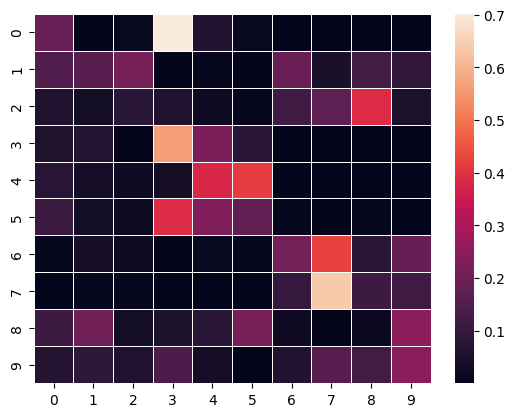

In [19]:
logits_per_text_vs_motion = out.logits_per_text_vs_motion 
probs = logits_per_text_vs_motion.softmax(dim=-1)
ax = sns.heatmap(np.array(probs.detach().cpu()), linewidth=0.5)
plt.show()

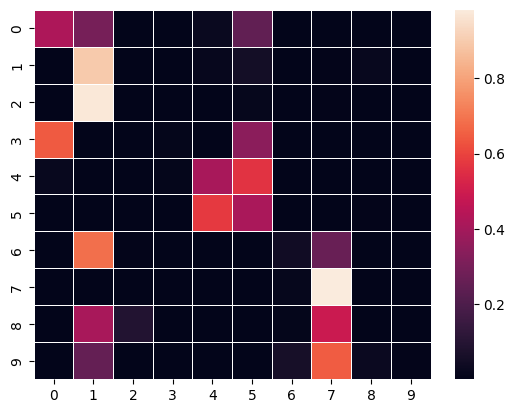

In [20]:
logits_per_motion_vs_text = out.logits_per_motion_vs_text
probs2 = logits_per_motion_vs_text.softmax(dim=-1)
ax = sns.heatmap(np.array(probs2.detach().cpu()), linewidth=0.5)
plt.show()

## TRAIN

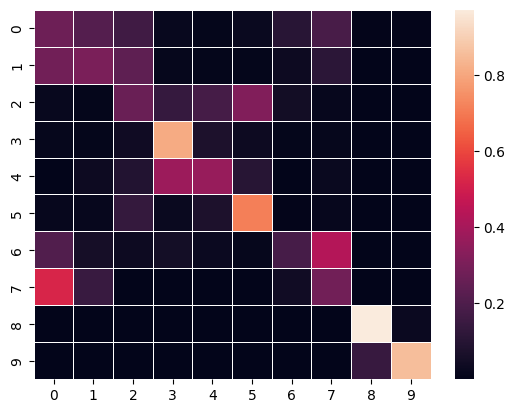

In [32]:
logits_per_text_vs_motion = out.logits_per_text_vs_motion 
probs = logits_per_text_vs_motion.softmax(dim=-1)
ax = sns.heatmap(np.array(probs.detach().cpu()), linewidth=0.5)
plt.show()

In [33]:
probs

tensor([[2.7008e-01, 2.1294e-01, 1.6599e-01, 1.9656e-02, 9.1111e-03, 2.4270e-02,
         1.0366e-01, 1.8259e-01, 5.8557e-03, 5.8450e-03],
        [2.8412e-01, 3.0181e-01, 2.3923e-01, 1.2673e-02, 8.9897e-03, 1.0776e-02,
         3.1088e-02, 1.1022e-01, 6.5181e-04, 4.4217e-04],
        [2.2720e-02, 1.0632e-02, 2.6337e-01, 1.4030e-01, 1.7782e-01, 3.1885e-01,
         4.6794e-02, 1.8789e-02, 4.7778e-04, 2.5179e-04],
        [1.1662e-02, 8.6468e-03, 3.8034e-02, 8.1036e-01, 7.2752e-02, 3.3828e-02,
         1.0902e-02, 1.3484e-02, 1.6856e-04, 1.6177e-04],
        [3.7603e-03, 3.3586e-02, 9.0984e-02, 3.7642e-01, 3.6588e-01, 1.0186e-01,
         3.3907e-03, 2.3532e-02, 1.4231e-04, 4.4999e-04],
        [1.7412e-02, 1.7750e-02, 1.3326e-01, 2.5547e-02, 7.3399e-02, 7.1044e-01,
         4.7794e-03, 1.5985e-02, 9.3038e-04, 4.9409e-04],
        [2.0661e-01, 5.5253e-02, 3.0442e-02, 5.2119e-02, 2.6663e-02, 1.4191e-02,
         1.8071e-01, 4.3204e-01, 5.2911e-04, 1.4418e-03],
        [5.2399e-01, 1.4469

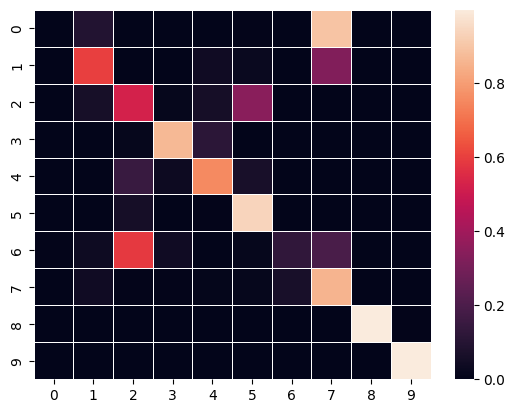

In [34]:
logits_per_motion_vs_text = out.logits_per_motion_vs_text
probs2 = logits_per_motion_vs_text.softmax(dim=-1)
ax = sns.heatmap(np.array(probs2.detach().cpu()), linewidth=0.5)
plt.show()

In [38]:
clamp_model.motion_model.codebook

Embedding(1024, 512)

In [172]:
n =int( sum(batch["motion_mask"][0]))

In [15]:
motion_outputs = clamp_model.motion_model(
                input_features=batch["input_motion_features"],
                motion_mask=batch["motion_mask"],
                return_dict=True,
            )

In [19]:
motion_outputs.motion_quantized.shape

torch.Size([2, 45, 512])

In [17]:
motion_outputs.pooler_output.shape

torch.Size([2, 512])

In [ ]:
class ResidualAttentionBlock(nn.Module):
    def __init__(self, d_model: int, n_head: int, act_layer: Callable = nn.GELU):
        super().__init__()

        self.attn = nn.MultiheadAttention(d_model, n_head)
        self.ln_1 = LayerNorm(d_model)
        self.mlp = nn.Sequential(
            OrderedDict(
                [
                    ("c_fc", nn.Linear(d_model, d_model * 4)),
                    ("gelu", act_layer()),
                    ("c_proj", nn.Linear(d_model * 4, d_model)),
                ]
            )
        )
        self.ln_2 = LayerNorm(d_model)

    def attention(self, x: torch.Tensor, attn_mask: Optional[torch.Tensor] = None):
        return self.attn(x, x, x, need_weights=False, attn_mask=attn_mask)[0]

    def forward(self, x: torch.Tensor, attn_mask: Optional[torch.Tensor] = None):
        x = x + self.attention(self.ln_1(x), attn_mask=attn_mask)
        x = x + self.mlp(self.ln_2(x))
        return x


class Transformer(nn.Module):
    def __init__(
        self, width: int, layers: int, heads: int, act_layer: Callable = nn.GELU
    ):
        super().__init__()
        self.width = width
        self.layers = layers
        self.resblocks = nn.ModuleList(
            [
                ResidualAttentionBlock(width, heads, act_layer=act_layer)
                for _ in range(layers)
            ]
        )

    def forward(self, x: torch.Tensor, attn_mask: Optional[torch.Tensor] = None):
        for r in self.resblocks:
            x = r(x, attn_mask=attn_mask)
        return x


In [178]:
motion_outputs.motion_embeds[0][: n//4]

tensor([[-0.3476, -0.3848, -0.3382,  ...,  1.2374,  1.4674, -2.1366],
        [-0.6643, -0.1604, -1.1021,  ...,  0.5524, -1.2188, -2.4285],
        [-0.4812, -0.7574, -1.0271,  ..., -0.4936,  1.6141, -2.4648],
        ...,
        [-0.7409, -0.1642, -0.5005,  ..., -0.7184,  0.2362, -0.9957],
        [-1.1092,  0.1609, -1.3755,  ..., -0.2261,  1.0162, -2.4969],
        [-1.0156,  0.1001, -1.6934,  ...,  0.4242,  1.1925, -2.5306]],
       grad_fn=<SliceBackward0>)

In [177]:
motion_outputs.motion_quantized[0][: n//4]

tensor([[ 0.7374,  0.1091, -0.9001,  ...,  0.9471,  0.4839, -1.7853],
        [-0.6063, -0.2402, -1.3614,  ..., -1.4479, -0.4712, -2.0911],
        [ 0.5954, -0.6793, -0.2143,  ..., -0.7939,  1.1101, -2.4060],
        ...,
        [ 0.4130, -1.0651,  0.4501,  ..., -0.1769,  0.1579, -1.4100],
        [ 0.1780, -0.5427, -0.3067,  ..., -0.3478,  0.5527, -2.9065],
        [-0.0870, -0.5428, -0.8138,  ..., -0.3544,  0.1502, -2.6137]])

### OG

In [129]:
motion_outputs.motion_embeds[0]

tensor([[-0.4184, -0.4447, -0.3431,  ...,  1.2462,  1.4885, -2.1719],
        [-0.4815, -0.2334, -1.2013,  ...,  0.5483, -1.2567, -2.4094],
        [-0.3224, -0.8071, -1.0123,  ..., -0.5272,  1.6135, -2.1802],
        ...,
        [-0.4755, -0.4051, -0.1536,  ..., -1.0224,  0.1503, -1.9890],
        [-1.7348,  0.5145, -1.3978,  ...,  0.0789,  0.8598, -2.9776],
        [-0.4824, -0.1940, -1.5952,  ...,  0.2725,  0.6000, -2.4318]],
       grad_fn=<SelectBackward0>)

In [130]:
motion_outputs.motion_quantized[0]

tensor([[ 0.7374,  0.1091, -0.9001,  ...,  0.9471,  0.4839, -1.7853],
        [-0.4930, -0.5167, -0.8416,  ..., -0.0847, -0.4262, -1.8722],
        [ 0.5954, -0.6793, -0.2143,  ..., -0.7939,  1.1101, -2.4060],
        ...,
        [ 0.4130, -1.0651,  0.4501,  ..., -0.1769,  0.1579, -1.4100],
        [ 0.0607, -0.4803, -0.3824,  ..., -0.3225,  0.4422, -2.5939],
        [ 0.6482, -0.8899, -0.6191,  ...,  0.0393,  0.8039, -2.2377]])

In [38]:
for i in os.listdir("/srv/hays-lab/scratch/sanisetty3/motionx/motion_data/new_joint_vecs"):
    motions = []
    for f in findAllFile(f"/srv/hays-lab/scratch/sanisetty3/motionx/motion_data/new_joint_vecs/{i}"):
        motions.append(np.load(f).shape[0])

    print(i , "mean" , np.mean(motions) , "std", np.std(motions) , "max" , max(motions) , "min" , min(motions))

moyo mean 380.77647058823527 std 156.56916355329534 max 950 min 162
music mean 244.91694725028057 std 112.2322020469831 max 943 min 1
EgoBody mean 446.9142857142857 std 117.16863305265865 max 679 min 82
fitness mean 213.24708485319618 std 127.85189517845544 max 1993 min 1
beat mean 1706.0 std 0.0 max 1706 min 1706
aist mean 426.40204211869815 std 893.2803941721178 max 10826 min 11
dance mean 221.6851851851852 std 195.8577359806965 max 1496 min 5
idea400 mean 206.37420076726343 std 65.0198867817423 max 569 min 1
HAA500 mean 58.56643089275473 std 40.42577510598959 max 391 min 4
kungfu mean 246.9153031761309 std 120.82275115239747 max 783 min 1
perform mean 214.8357894736842 std 109.75524149170757 max 553 min 3
GRAB mean 303.31760299625466 std 153.38501490937358 max 1114 min 122
humanml mean 211.2161495962601 std 80.59329265648283 max 299 min 4
choreomaster mean 4351.944444444444 std 1558.3454713331994 max 8142 min 886
game_motion mean 108.68687561214496 std 102.12329450829242 max 2918 mi

In [114]:
from datasets import load_dataset, Audio

from transformers import EncodecModel, AutoProcessor


In [131]:
model = EncodecModel.from_pretrained("facebook/encodec_24khz" ,  cache_dir="/srv/hays-lab/scratch/sanisetty3/huggingface_downloads").to(device)
processor = AutoProcessor.from_pretrained("facebook/encodec_24khz" , cache_dir ="/srv/hays-lab/scratch/sanisetty3/huggingface_downloads")

/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [ ]:
processor.

In [149]:
dataset = load_dataset("/srv/hays-lab/scratch/sanisetty3/motionx/audio/choreomaster/").cast_column("audio", Audio(sampling_rate=processor.sampling_rate))

Generating train split: 36 examples [00:00, 182.46 examples/s]


In [ ]:
audio_sample = librispeech_dummy[-1]["audio"]["array"]


In [138]:
len(dataset["train"])

1724

In [154]:
inputs = processor(raw_audio=dataset["train"][0]["audio"]["array"], sampling_rate=processor.sampling_rate, return_tensors="pt")


In [153]:
dataset["train"][0]

{'audio': {'path': '/coc/scratch/sanisetty3/motionx/audio/choreomaster/0071.wav',
  'array': array([ 0.23337187,  0.17842412, -0.01593026, ...,  0.        ,
          0.        ,  0.        ]),
  'sampling_rate': 24000}}

In [155]:
encoder_outputs = model.encode(inputs["input_values"].to(device), inputs["padding_mask"].to(device) , bandwidth = 6.0)

OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB. GPU 0 has a total capacty of 10.75 GiB of which 221.19 MiB is free. Including non-PyTorch memory, this process has 10.53 GiB memory in use. Of the allocated memory 9.17 GiB is allocated by PyTorch, and 311.13 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
encoder_outputs["audio_codes"].shape

In [144]:
audio_codes = model(inputs["input_values"].to(device), inputs["padding_mask"].to(device)).audio_codes